In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ovrolwasolar import deconvolve as odeconv
from ovrolwasolar import flagging as oflag
import copy

from baseline_optm import * 

from astropy.io import fits
from casatools import msmetadata, ms, table, quanta, measures

In [3]:
fname_fast_src = '/data07/peijinz/test-imaging/testdata/fast/20240519_173004_55MHz.ms'
fname_slow_src = '/data07/peijinz/test-imaging/testdata/slow/20240519_173002_55MHz_calibrated_selfcalibrated_sun_only.ms'
badant_csv = '/data07/peijinz/test-imaging/testdata/slow/20240519_173002_55MHz.badants'

# get the name of antenna from the header
msmd = msmetadata()
msmd.open(fname_fast_src)
fast_antenna_names = msmd.antennanames()
msmd.close()
msmd.open(fname_slow_src)
slow_antenna_names = msmd.antennanames()
msmd.close()

# read badant csv file
badant = np.loadtxt(badant_csv, delimiter=',', dtype='str')

# get antenna location and plot
msmd = msmetadata()
msmd.open(fname_slow_src)
ant_lat = []
ant_lon = []
antenna_positions = msmd.antennaposition()
antenna_names = msmd.antennanames()
for ant_ids in range(len(antenna_names)):
    ant_lat.append(msmd.antennaposition(ant_ids)['m0']['value'] * 180 / np.pi)
    ant_lon.append(msmd.antennaposition(ant_ids)['m1']['value'] * 180 / np.pi)
msmd.close()

True

In [4]:
# create a tmp dir and copy the ms files to the tmp
import os
import shutil
tmp_dir = '/data07/peijinz/test-imaging/testdata/tmp'
# rm the tmp dir if it exists
if os.path.exists(tmp_dir):
    shutil.rmtree(tmp_dir)
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)
# copy the ms folder to the tmp dir
shutil.copytree(fname_fast_src, os.path.join(tmp_dir, os.path.basename(fname_fast_src)))
shutil.copytree(fname_slow_src, os.path.join(tmp_dir, os.path.basename(fname_slow_src)))

fname_fast = os.path.join(tmp_dir, os.path.basename(fname_fast_src))
fname_slow = os.path.join(tmp_dir, os.path.basename(fname_slow_src))

In [5]:
# get the flagging from slow_ms file
if False:
    tb = table()
    tb.open(fname_slow)
    flagging_src = tb.getcol('FLAG')
    tb.close()

    # save the flagging to np file
    np.save('/data07/peijinz/test-imaging/testdata/flagging.npy', flagging_src)

In [6]:
badant = np.int32(badant)
bad_ant_names = [slow_antenna_names[int(i)] for i in badant]

In [7]:
ant_pool_to_iterate = np.setdiff1d(slow_antenna_names, bad_ant_names)
current_set_48 = copy.deepcopy(fast_antenna_names)

In [8]:
# in slow data, flag all antennas except the fast antennas

# get the flagging from np file
flagging_src = np.load('/data07/peijinz/test-imaging/testdata/flagging.npy')

# open the slow ms file
tb = table()
tb.open(fname_slow)
ant1 = tb.getcol('ANTENNA1')
ant2 = tb.getcol('ANTENNA2')
flagging = flagging_src.copy()
tb.close()

# flag all antennas except the fast antennas

for i in range(len(slow_antenna_names)):
    if slow_antenna_names[i] not in current_set_48:
        bad_ant1 = np.where(ant1 == i)[0]
        bad_ant2 = np.where(ant2 == i)[0]
        flagging[:,:,bad_ant1] = True
        flagging[:,:,bad_ant2] = True

# write the flagging to the slow ms file
tb.open(fname_slow, nomodify=False)
tb.putcol('FLAG', flagging)
tb.close()


True

In [9]:
#odeconv.run_wsclean(fname_slow_src, imagename='no_flag', auto_mask=5, minuv_l='0', predict=False,
#        size=512 , scale='2amin', pol='I', fast_vis=False, j=8,mem=10,beam_fitting_size=3)
odeconv.run_wsclean(fname_slow, imagename='flag_fast_ant', auto_mask=5, minuv_l='0', predict=False,
        size=512 , scale='2amin', pol='I', fast_vis=False, j=4,mem=5,beam_fitting_size=3,rm_misc=False)

'wsclean  -j 4  -mem 5  -weight uniform  -no-dirty  -no-update-model-required  -no-negative  -niter 10000  -mgain 0.8  -auto-threshold 3  -auto-mask 5  -pol I  -minuv-l 0  -intervals-out 1  -no-reorder  -beam-fitting-size 3  -horizon-mask 2deg  -quiet  -size 512 512  -scale 2amin  -field all  -name flag_fast_ant /data07/peijinz/test-imaging/testdata/tmp/20240519_173002_55MHz_calibrated_selfcalibrated_sun_only.ms'

SNR1:  116.45079
SNR2:  39.04725


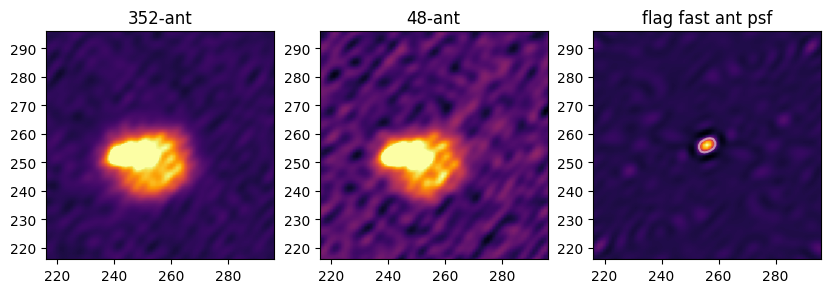

In [13]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

hdu1 = fits.open('no_flag-image.fits')
hdu2 = fits.open('flag_fast_ant-image.fits')
hdu3 = fits.open('flag_fast_ant-psf.fits')

ax1.imshow(hdu1[0].data[0,0,:,:], origin='lower', cmap='inferno',vmin=-50, vmax = np.percentile(hdu1[0].data[0,0,:,:], 99.95))
ax1.set_title('no flag')
ax2.imshow(hdu2[0].data[0,0,:,:], origin='lower', cmap='inferno',vmin=-50, vmax = np.percentile(hdu2[0].data[0,0,:,:], 99.95))
ax2.set_title('flag fast ant')
ax3.imshow(hdu3[0].data[0,0,:,:], origin='lower', cmap='inferno')
ax3.set_title('flag fast ant psf')
ax3.contour(hdu3[0].data[0,0,:,:], levels=[0.3], colors='white', alpha=0.5)

ax1.set_title('352-ant')
ax2.set_title('48-ant')
score1 = corner_rms(hdu1[0].data[0,0,:,:].squeeze())
score2 = corner_rms(hdu2[0].data[0,0,:,:].squeeze())
print("SNR1: ", score1)
print("SNR2: ", score2)

for ax in [ax1, ax2, ax3]:
    ax.set_xlim(256-40, 256+40)
    ax.set_ylim(256-40, 256+40)


In [14]:
old_set48_idx = np.array([slow_antenna_names.index(i) for i in current_set_48])

# random select 10 antennas from the slow which is not in the fast, replace random 10 antennas in the fast
sup_antenna_names = np.setdiff1d(ant_pool_to_iterate, current_set_48)
np.random.shuffle(sup_antenna_names)

# random select 10 antennas from the fast and replace them with the antennas in the slow
idx_to_be_replaced_in_cur = np.random.choice(len(current_set_48), 10, replace=False)
idx_in_slow_chosen = np.random.choice(len(sup_antenna_names), 10, replace=False)
replaced_antennas = [current_set_48[i] for i in idx_to_be_replaced_in_cur]
new_in_antennas = [sup_antenna_names[i] for i in idx_in_slow_chosen]

for i in range(10):
    current_set_48[idx_to_be_replaced_in_cur[i]] = sup_antenna_names[idx_in_slow_chosen[i]]

new_set48_idx = np.array([slow_antenna_names.index(i) for i in current_set_48])
replaced_idx = np.array([slow_antenna_names.index(i) for i in replaced_antennas])
new_in_idx = np.array([slow_antenna_names.index(i) for i in new_in_antennas])

In [15]:
'''
def corner_rms(img, cornerpix=100):
    img = img.squeeze()
    imgrms = np.concatenate([img[0:cornerpix,0:cornerpix], img[0:cornerpix,-cornerpix:], 
                             img[-cornerpix:,0:cornerpix], img[-cornerpix:,-cornerpix:]])
    return np.max(img)/np.std(imgrms)

def psf_peak_thresh_area(img, thresh=0.3):
    img = img.squeeze()
    peak = np.max(img)
    mask = img > 0.3*peak
    return np.sum(mask)
    return np.sum(mask)

def max_bonding_box(img, thresh=0.3):
    img = img.squeeze()
    mask = img > 0.3*np.max(img)
    mask = np.where(mask)
    # return the length of the bonding box diagonal
    return np.sqrt((np.max(mask[0])-np.min(mask[0]))**2 + (np.max(mask[1])-np.min(mask[1]))**2)
'''

'\ndef corner_rms(img, cornerpix=100):\n    img = img.squeeze()\n    imgrms = np.concatenate([img[0:cornerpix,0:cornerpix], img[0:cornerpix,-cornerpix:], \n                             img[-cornerpix:,0:cornerpix], img[-cornerpix:,-cornerpix:]])\n    return np.max(img)/np.std(imgrms)\n\ndef psf_peak_thresh_area(img, thresh=0.3):\n    img = img.squeeze()\n    peak = np.max(img)\n    mask = img > 0.3*peak\n    return np.sum(mask)\n    return np.sum(mask)\n\ndef max_bonding_box(img, thresh=0.3):\n    img = img.squeeze()\n    mask = img > 0.3*np.max(img)\n    mask = np.where(mask)\n    # return the length of the bonding box diagonal\n    return np.sqrt((np.max(mask[0])-np.min(mask[0]))**2 + (np.max(mask[1])-np.min(mask[1]))**2)\n'

In [52]:
# in slow data, flag all antennas except the fast antennas
out_standing = '84.31537,238;244;67;4;283;19;136;135;196;122;226;105;231;304;175;130;313;20;207;297;98;160;233;81;63;84;222;271;335;276;316;306;164;346;140;30;121;72;170;131;74;29;274;91;206;89;268;103,238;244;67;4;283;19;136;135;196;122;226;105;231;304;324;145;313;20;207;297;98;214;233;81;63;84;222;271;152;158;172;306;164;346;128;30;121;72;170;319;74;0;274;91;206;89;268;71,175;276;140;29;335;130;160;103;131;316,324;158;128;0;152;145;214;71;319;172,123'
#out_standing = '11.14587808036949,319;350;51;127;339;335;2;25;47;348;56;55;7;158;62;21;26;276;283;4;287;13;37;253;282;63;27;315;157;8;16;317;57;346;29;349;18;60;189;32;255;156;45;6;91;77;35;24,319;191;51;127;339;49;2;38;47;34;56;55;7;158;62;21;26;276;283;4;287;13;37;253;282;63;27;315;157;153;16;317;57;346;29;349;316;60;189;32;255;156;45;190;91;15;35;24,0;0;0;0;0;0;0;0,0;0;0;0;0;0;0;0,[36.34298]'
#out_standing = '13.534494698637868,319;58;259;9;190;282;4;50;30;48;38;191;8;49;40;349;25;92;13;90;287;27;0;21;338;63;283;124;123;23;324;348;55;93;54;157;47;339;189;19;312;34;6;39;22;60;20;122,319;58;259;9;190;282;250;50;30;48;38;191;8;49;40;349;25;92;26;90;287;27;0;21;338;63;52;36;123;23;324;348;55;284;109;157;45;32;189;19;1;34;6;39;24;60;20;122,13;339;124;4;283;47;54;93;312;22,26;32;36;250;52;45;109;284;1;24,44.720043;169;24.08318915758459'
out_standing = '13.05283755978716,125;25;191;20;283;209;124;69;197;50;206;284;312;95;319;24;74;299;38;53;339;55;253;42;152;49;223;90;252;346;0;317;5;122;349;70;350;45;348;92;186;9;266;326;59;170;54;157,125;25;191;20;283;209;124;69;197;282;206;284;312;95;319;24;74;46;38;53;251;55;253;42;152;49;223;90;252;346;48;317;5;122;349;35;190;45;348;92;186;9;43;93;59;170;54;157,50;299;70;0;339;350;326;266,282;46;35;48;251;190;93;43,44.39926;45;8.84963826628098'
out_standing = '13.044490043459092,60;25;191;314;51;209;124;303;197;282;351;284;221;95;1;24;120;46;38;53;251;55;101;42;152;49;223;90;252;346;48;317;5;122;349;35;189;123;348;304;0;9;43;93;23;170;165;157,18;25;191;314;51;209;124;303;197;282;283;284;221;95;1;24;120;319;38;53;251;55;101;42;152;49;223;90;13;81;48;317;5;122;349;35;188;123;348;304;91;9;43;93;22;170;165;157,23;346;0;189;351;252;60;46,22;81;91;188;283;13;18;319,53.483234;55;9.48420316861656'

snr, old_set, new_set, replaced, new_in, info = convert_str_to_var(out_standing)


new_set_to_test = [slow_antenna_names[i] for i in new_set]

# get the flagging from np file
flagging_src = np.load('/data07/peijinz/test-imaging/testdata/flagging.npy')

# open the slow ms file
tb = table()
tb.open(fname_slow)
ant1 = tb.getcol('ANTENNA1')
ant2 = tb.getcol('ANTENNA2')
flagging = flagging_src.copy()
tb.close()

# flag all antennas except the fast antennas

for i in range(len(slow_antenna_names)):
    if slow_antenna_names[i] not in new_set_to_test:
        bad_ant1 = np.where(ant1 == i)[0]
        bad_ant2 = np.where(ant2 == i)[0]
        flagging[:,:,bad_ant1] = True
        flagging[:,:,bad_ant2] = True

# write the flagging to the slow ms file
tb.open(fname_slow, nomodify=False)
tb.putcol('FLAG', flagging)
tb.close()

odeconv.run_wsclean(fname_slow, imagename='flag_fast_ant', auto_mask=5, minuv_l='0', predict=False,rm_misc=False,
        size=512 , scale='2amin', pol='I', fast_vis=False, j=4,mem=5,beam_fitting_size=3)



'wsclean  -j 4  -mem 5  -weight uniform  -no-dirty  -no-update-model-required  -no-negative  -niter 10000  -mgain 0.8  -auto-threshold 3  -auto-mask 5  -pol I  -minuv-l 0  -intervals-out 1  -no-reorder  -beam-fitting-size 3  -horizon-mask 2deg  -quiet  -size 512 512  -scale 2amin  -field all  -name flag_fast_ant /data07/peijinz/test-imaging/testdata/tmp/20240519_173002_55MHz_calibrated_selfcalibrated_sun_only.ms'

SNR1: 116.45079
SNR2: 51.807823
beam_area: 33


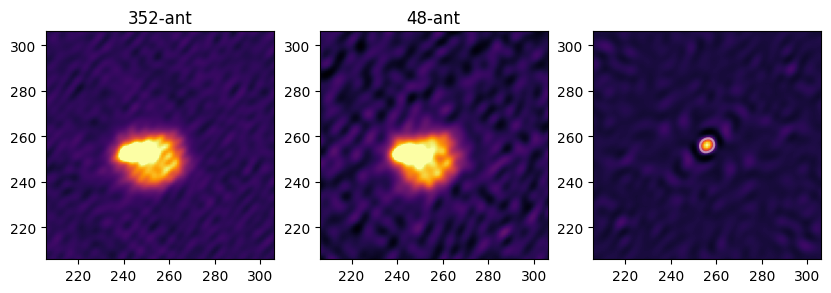

In [53]:

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

hdu1 = fits.open('no_flag-image.fits')
hdu2 = fits.open('flag_fast_ant-image.fits')

dataimg1 = hdu1[0].data[0,0,:,:].squeeze()
dataimg2 = hdu2[0].data[0,0,:,:].squeeze()

ax1.imshow(dataimg1, origin='lower', cmap='inferno', vmin=-50, vmax = np.percentile(dataimg1, 99.95))
ax2.imshow(dataimg2, origin='lower', cmap='inferno', vmin=-50, vmax = np.percentile(dataimg2, 99.95))
score1 = corner_rms(dataimg1)
score2 = corner_rms(dataimg2)
print('SNR1:', score1)
print('SNR2:', score2)
ax3 = fig.add_subplot(133)
hdu3 = fits.open('flag_fast_ant-psf.fits') 
ax3.imshow(hdu3[0].data[0,0,:,:], origin='lower', cmap='inferno')
ax3.contour(hdu3[0].data[0,0,:,:], levels=[0.3], colors='white', alpha=0.5)


for ax in [ax1, ax2, ax3]:
    ax.set_xlim(256-50, 256+50)
    ax.set_ylim(256-50, 256+50)

ax1.set_title('352-ant')
ax2.set_title('48-ant')

print('beam_area:', psf_peak_thresh_area(hdu3[0].data[0,0,:,:]))

In [54]:
peak03_score = psf_peak_thresh_area(dataimg1)
maxbox_score = max_bonding_box(dataimg1)

In [55]:
# scale to "asec"
print('peak03_score:', peak03_score*(hdu1[0].header['CDELT1'])**2)
print('maxbox_score:', maxbox_score*np.abs(hdu1[0].header['CDELT1']))


peak03_score: 0.3299999999999993
maxbox_score: 1.0077477638553973


In [56]:
ant_lat = np.array(ant_lat)
ant_lon = np.array(ant_lon)

In [57]:


tb = table()
me = measures()
msmd = msmetadata()


def get_antids(msfile):
    """
    Read antenna ids from a measurement set and separate them to inner and expansion ones

    :param msfile: path to CASA measurement set
    :return: antenna ids for core antennas and expansion antennas
    """
    tb.open(msfile + '/ANTENNA')
    ms_ant_names = tb.getcol('NAME')
    tb.close()
    msmd = msmetadata()
    msmd.open(msfile)
    core_ant_name_list = ['LWA{0:03d}'.format(i + 1) for i in range(0, 251)]
    exp_ant_name_list = ['LWA{0:03d}'.format(i + 1) for i in range(251, 366)]
    core_ant_ids = []
    exp_ant_ids = []
    for ms_ant_name in ms_ant_names:
        if ms_ant_name in core_ant_name_list:
            core_ant_ids.append(msmd.antennaids(ms_ant_name)[0])
        if ms_ant_name in exp_ant_name_list:
            exp_ant_ids.append(msmd.antennaids(ms_ant_name)[0])

    msmd.close()
    return np.array(core_ant_ids), np.array(exp_ant_ids)

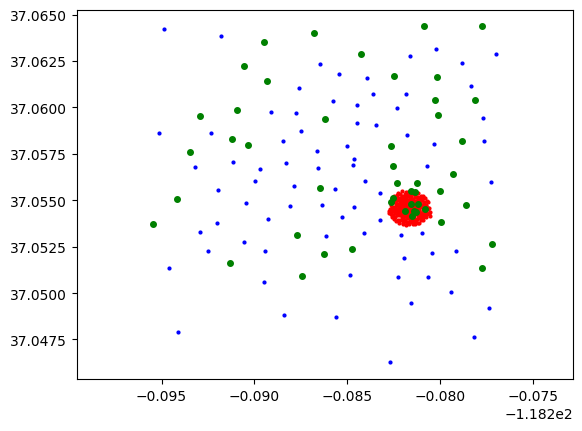

In [58]:
import ovrolwasolar.flagging as oflag


core_id, ext_id = get_antids(fname_slow_src)

core_id = core_id

fig, ax = plt.subplots()
ax.plot(ant_lat[np.int32(core_id)], ant_lon[np.int32(core_id)], 'r.', label='core',
        ms=4)
ax.plot(ant_lat[np.int32(ext_id)], ant_lon[np.int32(ext_id)], 'b.', label='ext',
        ms=4)

# plot current set 48
ant_idx_48 = [slow_antenna_names.index(i) for i in new_set_to_test]
ax.plot(ant_lat[ant_idx_48], ant_lon[ant_idx_48], 'g.', label='48-ant', ms=8)

# axis equal
ax.set_aspect('equal', adjustable='datalim')



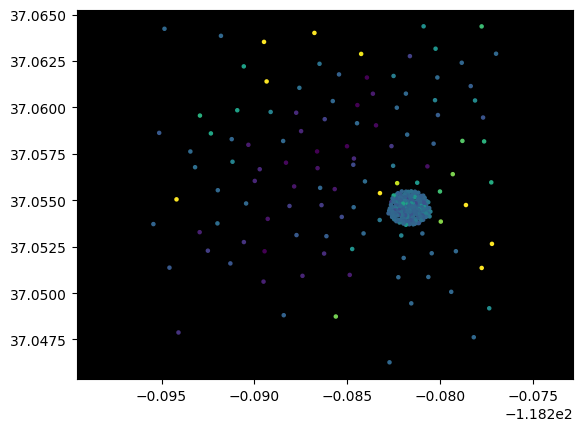

In [72]:
# load sore book from txt file
with open('/data07/peijinz/test-imaging/testdata/antenna_score_book.txt', 'r') as f:
    score_all = (np.fromstring(f.read(), sep='\n'))

fig, ax = plt.subplots()
ax.scatter(ant_lat, ant_lon, c=score_all, s=5,vmax=2, vmin=0.5)
# background color black
ax.set_facecolor('black')
# equal axis
ax.set_aspect('equal', adjustable='datalim')

In [53]:
core_id.shape

(243,)

In [ ]:
#[init]   idx:   0; score:12.50; snr:39.05; Abeam:175.00; dbeam26.08
#[accept]         idx:128         score:13.53●    snr:44.72●      Abeam:169.00●   dbeam:24.08●